## Multilingual Language Classifier — End-to-End Notebook  

**This notebook demonstrates language classification tasks using the MASSIVE multilingual dataset.**
 
DATASET_LINK :  https://huggingface.co/datasets/qanastek/MASSIVE


```bash
00-Intro      │ project description, imports
01-Config     │ language list & helper dicts
02-DataLoad   │ MASSIVE download & split to train/val/test
03-EDA        │ bar plots of sentence length, class counts
04-TrainLang  │ TF-IDF + MultinomialNB  
05-TrainCont  │ TF-IDF + SVD + LDA & QDA 
06-SaveModels │ joblib.dump to artifacts/  (same paths as PredictPipeline)
07-Evaluate   │ confusion matrices & macro-accuracy on test split
08-QuickDemo  │ load pickles with your  PredictionPipeline()
```

In [ ]:
# Core imports
import os,json,sys,warnings
import joblib,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

from pathlib import Path
from typing import List, Tuple

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
                                          
warnings.filterwarnings("ignore")

In [1]:
# Core imports
import os, json 
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [ ]:
massive_dataset = load_dataset("qanastek/MASSIVE", "en-US", split='test', trust_remote_code=True)
print(massive_dataset)
print(massive_dataset[0])

In [2]:
# Setup directory and languages
# Paths
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [3]:
# 27 Roman-script locales
LANGS = [
    "af-ZA","da-DK","de-DE","en-US","es-ES","fr-FR","fi-FI","hu-HU","is-IS","it-IT",
    "jv-ID","lv-LV","ms-MY","nb-NO","nl-NL","pl-PL","pt-PT","ro-RO","ru-RU","sl-SL",
    "sv-SE","sq-AL","sw-KE","tl-PH","tr-TR","vi-VN","cy-GB",
]

In [4]:
# locale → continent

CONTINENT = dict(
    ZA="Africa", KE="Africa",
    AL="Europe", GB="Europe", DK="Europe", DE="Europe", ES="Europe", FR="Europe",
    FI="Europe", HU="Europe", IS="Europe", IT="Europe", LV="Europe", NO="Europe",
    NL="Europe", PL="Europe", PT="Europe", RO="Europe", RU="Europe", SL="Europe",
    SE="Europe",
    ID="Asia", MY="Asia", PH="Asia", TR="Asia", VN="Asia",
    US="North America",
)
def to_continent(locale): return CONTINENT.get(locale.split("-")[1], "Unknown")


In [5]:
# Load Datasets

def load_split(langs, split):
    frames = []
    for loc in langs:
        ds = load_dataset("qanastek/MASSIVE", loc, split=split, trust_remote_code=True)
        df = pd.DataFrame(ds)[["locale","utt"]]
        df["split"] = split
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

train_df = load_split(LANGS,"train")
val_df   = load_split(LANGS,"validation")
test_df  = load_split(LANGS,"test")

for df in (train_df,val_df,test_df):
    df["continent"] = df["locale"].apply(to_continent)

print(train_df.shape, val_df.shape, test_df.shape)


Using the latest cached version of the module from C:\Users\singh\.cache\huggingface\modules\datasets_modules\datasets\qanastek--MASSIVE\31cdffab94ac97bfe5a394b1e96344c96f0ad847e1d796c7562d8c8b449e22e6 (last modified on Sun Jun 15 18:26:08 2025) since it couldn't be found locally at qanastek/MASSIVE, or remotely on the Hugging Face Hub.


(310878, 4) (54891, 4) (80298, 4)


In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

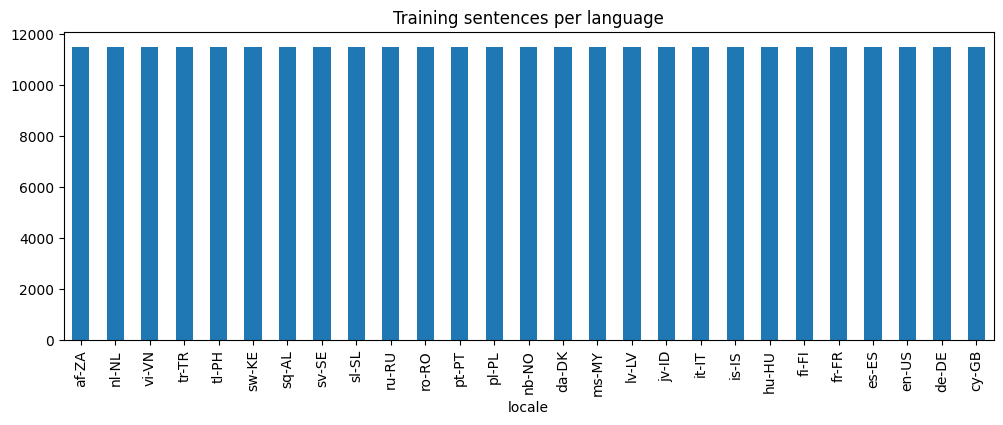

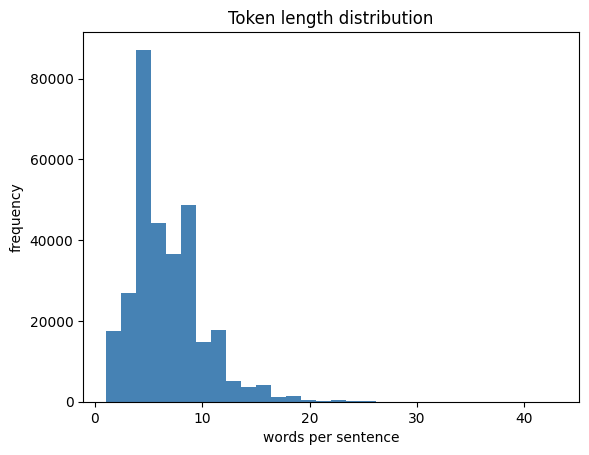

In [6]:
# EDA Plots

plt.figure(figsize=(12,4))
train_df['locale'].value_counts().plot(kind='bar')
plt.title("Training sentences per language")
plt.show()

# Sentence length histogram
lens = train_df['utt'].str.split().apply(len)
plt.hist(lens, bins=30, color='steelblue')
plt.title("Token length distribution")
plt.xlabel("words per sentence"); plt.ylabel("frequency")
plt.show()


In [7]:
# Train Language Classifier

tfidf_lang = TfidfVectorizer(ngram_range=(1,3), analyzer="char_wb", max_features=10_000)
Xtr = tfidf_lang.fit_transform(train_df['utt'])
Xval = tfidf_lang.transform(val_df['utt'])
Xte = tfidf_lang.transform(test_df['utt'])

nb = MultinomialNB(alpha=0.1)
nb.fit(Xtr, train_df['locale'])

print("Validation accuracy:", accuracy_score(val_df['locale'], nb.predict(Xval)))
print("Test accuracy:", accuracy_score(test_df['locale'], nb.predict(Xte)))


Validation accuracy: 0.9686833907197901
Test accuracy: 0.9698996239009688


In [8]:
# Train Continent Classifier (LDA & QDA)

tfidf_cont = TfidfVectorizer(max_features=15_000)
svd = TruncatedSVD(100, random_state=42)

Xtr_c = svd.fit_transform(tfidf_cont.fit_transform(train_df['utt']))
Xval_c = svd.transform(tfidf_cont.transform(val_df['utt']))
Xte_c = svd.transform(tfidf_cont.transform(test_df['utt']))

lda = LinearDiscriminantAnalysis().fit(Xtr_c, train_df['continent'])
qda = QuadraticDiscriminantAnalysis().fit(Xtr_c, train_df['continent'])

print("LDA  test acc:", accuracy_score(test_df['continent'], lda.predict(Xte_c)))
print("QDA  test acc:", accuracy_score(test_df['continent'], qda.predict(Xte_c)))


LDA  test acc: 0.8902587860220678
QDA  test acc: 0.8117014122394082


AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

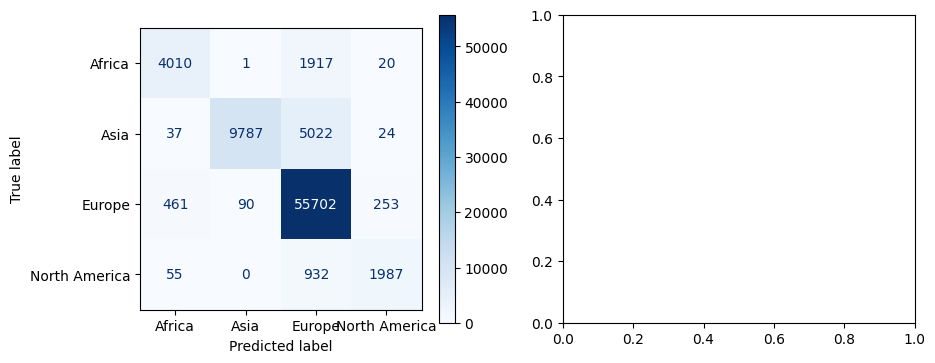

In [9]:
# Confusion Matrix

fig, ax = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay.from_estimator(lda, Xte_c, test_df['continent'], ax=ax[0], cmap='Blues')
ax.set_title("LDA Confusion")
ConfusionMatrixDisplay.from_estimator(qda, Xte_c, test_df['continent'], ax=ax[1], cmap='Greens')
ax[1].set_title("QDA Confusion")
plt.show()


In [ ]:
# Save models & artifacts

joblib.dump(nb,          f"{ARTIFACT_DIR}/language_model.pkl")
joblib.dump(tfidf_lang,  f"{ARTIFACT_DIR}/language_vectorizer.pkl")

# light-weight full pipeline (.pkl) exactly what PredictPipeline expects
from sklearn.pipeline import Pipeline
lang_pipe = Pipeline([("tfidf", tfidf_lang), ("nb", nb)])
joblib.dump(lang_pipe,   f"{ARTIFACT_DIR}/language_pipeline.pkl")

joblib.dump(tfidf_cont,  f"{ARTIFACT_DIR}/continent_vectorizer.pkl")
joblib.dump(svd,         f"{ARTIFACT_DIR}/continent_svd.pkl")
joblib.dump(lda,         f"{ARTIFACT_DIR}/continent_lda_model.pkl")
joblib.dump(qda,         f"{ARTIFACT_DIR}/continent_qda_model.pkl")

# Label encoders
from sklearn.preprocessing import LabelEncoder
le_cont = LabelEncoder().fit(train_df['continent'])
joblib.dump(le_cont,     f"{ARTIFACT_DIR}/continent_label_encoder.pkl")

# Performance summary json
summary = {
    "language_val_acc": accuracy_score(val_df['locale'], nb.predict(Xval)),
    "language_test_acc": accuracy_score(test_df['locale'], nb.predict(Xte)),
    "continent_lda_test_acc": accuracy_score(test_df['continent'], lda.predict(Xte_c)),
    "continent_qda_test_acc": accuracy_score(test_df['continent'], qda.predict(Xte_c)),
}
joblib.dump(summary, f"{ARTIFACT_DIR}/model_performance.pkl")
print("✅ Artifacts saved to", ARTIFACT_DIR)


In [10]:
# Evaluate on Test Split
print(classification_report(test_df['locale'], nb.predict(Xte)))
print("\n---\n")
print(classification_report(test_df['continent'], lda.predict(Xte_c), zero_division=0))


              precision    recall  f1-score   support

       af-ZA       0.95      0.95      0.95      2974
       cy-GB       0.99      0.99      0.99      2974
       da-DK       0.92      0.88      0.90      2974
       de-DE       0.98      0.97      0.97      2974
       en-US       0.89      0.97      0.93      2974
       es-ES       0.95      0.96      0.95      2974
       fi-FI       0.99      0.98      0.99      2974
       fr-FR       0.99      0.98      0.98      2974
       hu-HU       1.00      0.99      0.99      2974
       is-IS       1.00      0.99      0.99      2974
       it-IT       0.96      0.98      0.97      2974
       jv-ID       0.95      0.95      0.95      2974
       lv-LV       0.99      0.99      0.99      2974
       ms-MY       0.96      0.97      0.96      2974
       nb-NO       0.90      0.92      0.91      2974
       nl-NL       0.95      0.94      0.95      2974
       pl-PL       1.00      0.98      0.99      2974
       pt-PT       0.97    

In [ ]:
# Quick Demo with PredictionPipeline

# Ensure src is on path
import sys, pathlib, importlib
sys.path.append(str(pathlib.Path().resolve() / "src"))
from pipeline.predict_pipeline import PredictionPipeline

pipe = PredictionPipeline()
for sentence in ["Bonjour tout le monde", "Hola, ¿qué tal?", "Sveiki, kaip sekasi?"]:
    print(pipe.predict_both(sentence))
